<a href="https://colab.research.google.com/github/medsellufbc/BMI/blob/main/ExpSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 65.3 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=15cb93da582d922fa8c0272e03688f161b5fee01e35c09c1e86abec2f8bf491d
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib
import matplotlib.pyplot as plt             #visualisation
from IPython.display import display, Markdown
import warnings
warnings.simplefilter("ignore")
import pymc3 as pm
sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

%matplotlib inline     
sns.set(color_codes=True)

import arviz as az

sampler_kwargs = {"chains": 4, "cores": 4, "return_inferencedata":True}
from scipy.special import expit as logistic


In [15]:
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required

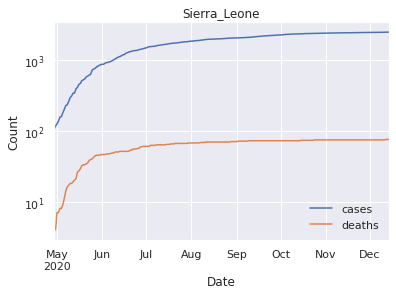

In [16]:
# Filter for country (probably want separate models per country, even maybe per region)
country = df[df["country"] == "Sierra_Leone"].sort_values(by="date")
# Cumulative sum of data
country_cumsum = country[["cases", "deaths"]].cumsum().set_index(country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]
country_cumsum.plot(logy=True)
plt.gca().set(xlabel="Date", ylabel="Count", title="Sierra_Leone")
plt.show()

In [17]:
country = "Sierra_Leone"
days_since_100 = range(len(country_cumsum))

# Create PyMC3 context manager
with pm.Model() as model1:
  t = pm.Data(country + "x_data", days_since_100)
  confirmed_cases = pm.Data(country + "y_data", country_cumsum["cases"].astype('float64').values)

  # Intercept - We fixed this at 100.
  a = pm.Normal("a", mu=100, sigma=10)

  # Slope - Growth rate: 0.2 is approx value reported by others
  b = pm.Normal("b", mu=0.2, sigma=0.5)

  # Exponential regression
  growth = a * (1 + b) ** t

  # Likelihood error
  eps = pm.HalfNormal("eps")

  # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
  pm.Lognormal(country, mu=np.log(growth), sigma=eps, observed=confirmed_cases)

  trace = pm.sample()
  post_Pred = pm.sample_posterior_predictive(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


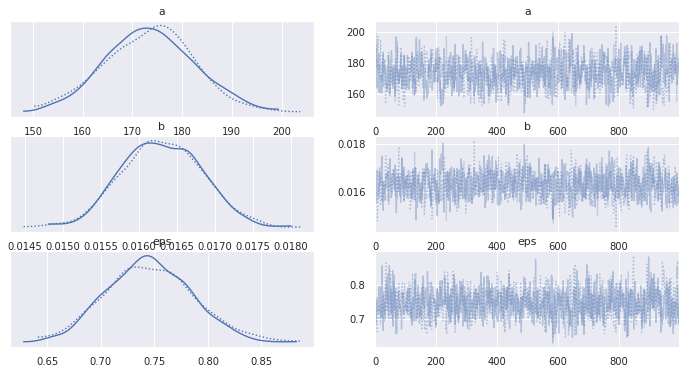

In [18]:
pm.traceplot(trace)
plt.show()

In [19]:
pm.summary(trace).round(2)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,173.56,8.92,155.45,189.47,0.34,0.24,691.0,973.0,1.0
b,0.02,0.00,0.02,0.02,0.00,0.00,811.0,924.0,1.0
eps,0.75,0.04,0.67,0.82,0.00,0.00,746.0,998.0,1.0


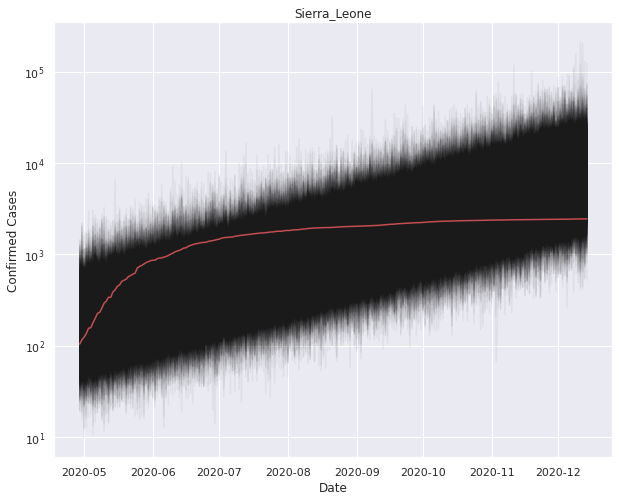

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(country_cumsum.index, post_Pred[country].T, color="k", alpha=0.05)
ax.plot(country_cumsum.index, country_cumsum["cases"].astype('float64').values, color="r")
ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title=country)
plt.show()